## Imports

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
import torch
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

## Loading dataset

### Paths

In [2]:
train_path = "./RoadExtractionDataset/train"
train_small_path = "./RoadExtractionDataset/train_small"
val_path = "./RoadExtractionDataset/valid"
test_path = "./RoadExtractionDataset/test"

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class RoadExtractionData(Dataset):
    def __init__(self, path, img_transform = None, mask_transform = None):
        self.path = Path(path)
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.sat_files = sorted(glob(path + '/*sat.jpg'))
        self.mask_files = sorted(glob(path + '/*mask.png'))
        
    def __getitem__(self, index):
        sat_path = self.sat_files[index]
        mask_path = self.mask_files[index]
        sat_img = Image.open(sat_path)
        mask_img = Image.open(mask_path)
        if self.img_transform and self.mask_transform:
            sat_img = self.img_transform(sat_img)
            mask_img = self.mask_transform(mask_img)
        return sat_img, mask_img
        
    def __len__(self):
        return len(self.sat_files)
    

In [4]:
example_dataset = RoadExtractionData(train_path)
print(example_dataset.__len__())

6226


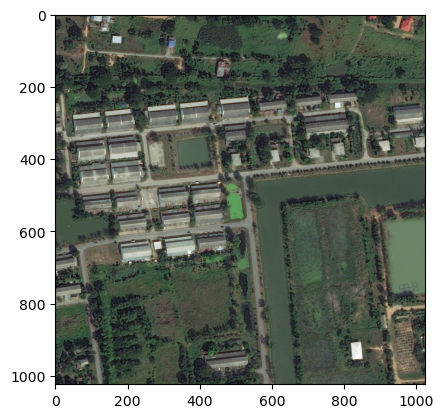

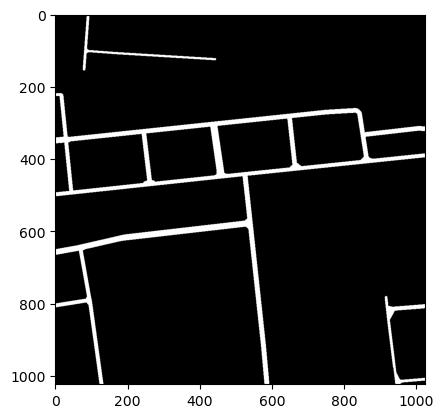

In [5]:
sat_img, mask_img = example_dataset.__getitem__(1337)
plt.imshow(sat_img)
plt.show()

plt.imshow(mask_img)
plt.show()


## Preprocessing

In [6]:
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([128,128])])
mask_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([128,128]), transforms.Grayscale()])

## Data Loader

In [7]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataset = RoadExtractionData(train_small_path, img_transform, mask_transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, valid_size])
#val_dataset = RoadExtractionData(val_path, img_transform, mask_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Model

In [29]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_batch):
        # Encoder
        xe11 = F.relu(self.e11(input_batch))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))
        
        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        print(out.size())
        out = self.sigmoid(out)
        
        print("model out", out)

        return out

        

## Training

In [30]:
def output_to_label(z):
    """Map network output z to a hard label {0, 1}
    
    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    # YOUR CODE HERE
    c = z.round().long()

    return c

In [31]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set print_every to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [41]:
def training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device):
    model.to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        for batch in train_dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= len(val_dataloader)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {val_loss:.4f}")
    
    print("Training complete.")

# Assuming you want to run the training loop for 5 epochs
model = UNet()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Assuming 'train_dataloader' and 'val_dataloader' are your training and validation data loaders
epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loop_training = training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device)

torch.Size([64, 1, 128, 128])
model out tensor([[[[0.4687, 0.4689, 0.4696,  ..., 0.4692, 0.4690, 0.4685],
          [0.4691, 0.4690, 0.4690,  ..., 0.4684, 0.4686, 0.4680],
          [0.4690, 0.4684, 0.4678,  ..., 0.4685, 0.4684, 0.4677],
          ...,
          [0.4684, 0.4680, 0.4690,  ..., 0.4674, 0.4670, 0.4681],
          [0.4691, 0.4686, 0.4686,  ..., 0.4684, 0.4674, 0.4679],
          [0.4683, 0.4681, 0.4684,  ..., 0.4684, 0.4684, 0.4685]]],


        [[[0.4689, 0.4681, 0.4691,  ..., 0.4691, 0.4687, 0.4682],
          [0.4694, 0.4685, 0.4688,  ..., 0.4686, 0.4691, 0.4681],
          [0.4687, 0.4679, 0.4680,  ..., 0.4681, 0.4684, 0.4681],
          ...,
          [0.4687, 0.4680, 0.4684,  ..., 0.4680, 0.4685, 0.4683],
          [0.4691, 0.4683, 0.4683,  ..., 0.4685, 0.4684, 0.4681],
          [0.4684, 0.4681, 0.4684,  ..., 0.4682, 0.4685, 0.4686]]],


        [[[0.4691, 0.4682, 0.4691,  ..., 0.4691, 0.4688, 0.4682],
          [0.4699, 0.4685, 0.4686,  ..., 0.4683, 0.4688, 0.4681]

torch.Size([61, 1, 128, 128])
model out tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
      

In [ ]:
model = UNet()

loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

loop_training = training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, 1, 1)

In [42]:
def preprocess(pil_img):
        img = np.asarray(pil_img)
        
        if img.ndim == 2:
            img = img[np.newaxis, ...]
        else:
            img = img.transpose((2, 0, 1))

        if (img > 1).any():
            img = img / 255.0

        return img

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

predict_transform = transforms.Compose([transforms.ToTensor()])

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    print("full img", full_img)
    print("full img np", np.asarray(full_img))
    img = predict_transform(full_img)
    print("img1", img)
    img = img.unsqueeze(0)
    print("img2", img)
    img = img.to(device=device, dtype=torch.float32)
    print("img3", img)

    with torch.no_grad():
        output = net(img).cpu()
        print("output", output)
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        print("output2", output)
        print("sigmoid out", torch.sigmoid(output))
        mask = output > out_threshold
        print("mask", mask)

    return mask[0].long().squeeze().numpy()

In [44]:
img = Image.open("./RoadExtractionDataset/train_small/104_sat.jpg")
pred = predict_img(model, img, device)

full img <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7FA1B0071520>
full img np [[[145 121  85]
  [155 131  95]
  [176 152 116]
  ...
  [123 102  71]
  [121 100  69]
  [115  94  63]]

 [[135 111  75]
  [141 117  81]
  [153 129  93]
  ...
  [131 110  79]
  [126 105  74]
  [121 100  69]]

 [[129 105  71]
  [135 111  77]
  [134 110  76]
  ...
  [134 113  82]
  [130 109  78]
  [125 104  73]]

 ...

 [[128 102  67]
  [127 101  66]
  [132 106  71]
  ...
  [102  86  60]
  [102  86  60]
  [106  90  64]]

 [[131 102  68]
  [131 102  68]
  [134 105  71]
  ...
  [103  87  61]
  [108  92  66]
  [105  89  63]]

 [[135 106  72]
  [133 104  70]
  [134 105  71]
  ...
  [105  89  63]
  [108  92  66]
  [106  90  64]]]
img1 tensor([[[0.5686, 0.6078, 0.6902,  ..., 0.4824, 0.4745, 0.4510],
         [0.5294, 0.5529, 0.6000,  ..., 0.5137, 0.4941, 0.4745],
         [0.5059, 0.5294, 0.5255,  ..., 0.5255, 0.5098, 0.4902],
         ...,
         [0.5020, 0.4980, 0.5176,  ..., 0.4000, 0.4

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


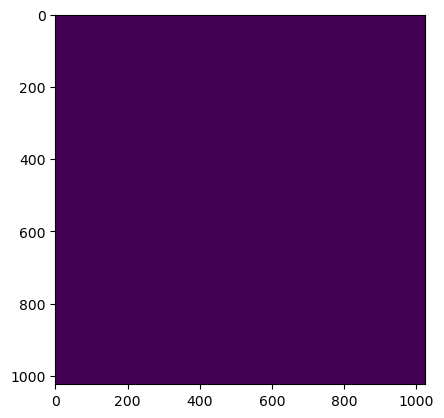

In [45]:
plt.imshow(pred)
print(pred)